## Importing Required libraries

In [1]:
# Analysing data
import pandas as pd
import numpy as np

# Visualizating the data
from matplotlib import pyplot as plt
import seaborn as sns

# Processing the data
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import string

# Machine Learning part
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix, roc_auc_score, roc_curve,auc
from sklearn.metrics import confusion_matrix, classification_report, log_loss, precision_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading datasets

In [2]:
train_data = pd.read_csv("datasets/tweet_analysis_train.csv",encoding = "utf-8",engine = "python",header = 0)

test_data = pd.read_csv("datasets/tweet_analysis_test.csv",encoding = "utf-8",engine = "python",header = 0)

### Getting info about the datasets

In [3]:
print("Train set shape : ", train_data.shape)
print("Test set shape : ", test_data.shape)
print(train_data.info())
#train_data

Train set shape :  (31962, 3)
Test set shape :  (17197, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB
None


## Preparing the dataset

In [4]:
## Dropping the column 'id'
train_data = train_data.drop('id', axis = 'columns')

## Checkinf for duplicates
print("Total duplicates in train set : ", train_data.duplicated().sum())

Total duplicates in train set :  2432


#### Since the train data set contains duplicate we will remove that

In [5]:
train_data = train_data.drop_duplicates(keep = 'first')
print("Total duplicates in train set : ", train_data.duplicated().sum())

Total duplicates in train set :  0


In [6]:
## Checking for the Null
train_data.isnull().any()

label    False
tweet    False
dtype: bool

### Now check for the count of 1 and 0 in the label and also the percentage of them 

In [7]:
train_data.groupby('label').count()

,tweet
label,
0,27517
1,2013


In [8]:
Zeroes = 100 * len(train_data.loc[train_data['label'] == 0,'label']) / len(train_data['label'])
Ones = 100 * len(train_data.loc[train_data['label'] == 1,'label']) / len(train_data['label'])
print("Percentage of Zeroes(Positive) Sentiment tweets is : ", Zeroes)
print("Percentage of Ones(Negative) Sentiment tweets is : ", Ones)
print("\nAs we can see, The training dataset is very much Imbalanced")

Percentage of Zeroes(Positive) Sentiment tweets is :  93.18320352184219
Percentage of Ones(Negative) Sentiment tweets is :  6.816796478157806

As we can see, The training dataset is very much Imbalanced


### Now we will get 20 most frequent words in the train dataset

In [9]:
Count = CountVectorizer(stop_words='english')
words = Count.fit_transform(train_data.tweet)
Sum = words.sum(axis = 0)
List = [(words, Sum[0,j]) for words, j in Count.vocabulary_.items()]
List = sorted(List, key= lambda x : x[1], reverse = True)
Freq = pd.DataFrame(List, columns = ['word', 'frequency'])
print(Freq)

           word  frequency
0          user      17211
1          love       2274
2           day       2211
3           amp       1668
4         happy       1580
...         ...        ...
41099       isz          1
41100  airwaves          1
41101    mantle          1
41102   shirley          1
41103   chisolm          1

[41104 rows x 2 columns]


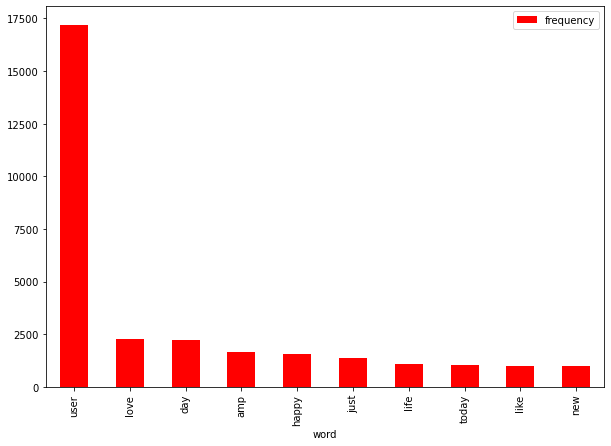

In [10]:
## Plotting a histogram to show it graphically
Freq.head(10).plot(x = 'word', y = 'frequency', kind = 'bar', figsize = (10, 7), color = 'red')
plt.show()

### Now we will define functions to calculate , words, characters, Hashtags, Numbers, stopwords etc.

In [11]:
## Words count
def Count_words(dataframe):
    dataframe['words'] = dataframe['tweet'].apply(lambda x : len(str(x).split(" ")))
    
## Characters Count
def Count_chars(dataframe):
    dataframe['characters'] = dataframe['tweet'].apply(lambda x : sum(list(map(len, x.split(' ')))))
    
## Hastags count
def Count_hashtags(dataframe):
    dataframe['hashtags'] = dataframe['tweet'].apply(lambda x : len([x for x in x.split() if x.startswith('#')]))
    
## stopwords count
def Count_stopwords(dataframe):
    stopword = stopwords.words('english')
    dataframe['stopwords'] = dataframe['tweet'].apply(lambda x : len([x for x in x.split() if x in stopword]))
    
## Numbers count
def Count_words(dataframe):
    dataframe['numbers'] = dataframe['tweet'].apply(lambda x : len([x for x in x.split() if x.isdigit()]))
    
    
def Calculate(dataframe):
    Count_words(dataframe)
    Count_chars(dataframe)
    Count_hashtags(dataframe)
    Count_stopwords(dataframe)
    Count_words(dataframe)

Calculate(train_data)
Calculate(test_data)
train_data

,label,tweet,numbers,characters,hashtags,stopwords
0,0,@user when a father is dysfunctional and is s...,0,82,1,10
1,0,@user @user thanks for #lyft credit i can't us...,0,101,3,5
2,0,bihday your majesty,0,17,0,1
3,0,#model i love u take with u all the time in ...,0,70,1,5
4,0,factsguide: society now #motivation,0,32,1,1
...,...,...,...,...,...,...
31956,0,off fishing tomorrow @user carnt wait first ti...,1,49,0,2
31957,0,ate @user isz that youuu?ðððððð...,0,63,0,1
31958,0,to see nina turner on the airwaves trying to...,0,107,2,9
31959,0,listening to sad songs on a monday morning otw...,0,49,0,5


### Now cleaning and processing the dataset

In [12]:
stopword = stopwords.words('english')
stemm = nltk.SnowballStemmer('english')

def Delete(word):
    word = str(word).lower()
    word = re.sub('\[.*?\]', '', word)
    word = re.sub('https?://\S+|www\.\S+', '', word)
    word = re.sub('<.*?>+', '', word)
    word = re.sub('[%s]' % re.escape(string.punctuation), '', word)
    word = re.sub('\n', '', word)
    word = re.sub('\w*\d\w*', '', word)
    word = [text for text in word.split(' ') if text not in stopword]
    word =" ".join(word)
    word = [stemm.stem(text) for text in word.split(' ')]
    word =" ".join(word)
    return word

train_data['tweet'] = train_data['tweet'].apply(Delete)
test_data['tweet'] = test_data['tweet'].apply(Delete)
##train_data
##Process(test_data)

In [13]:
train_x, test_x, train_y, test_y = train_test_split(train_data['tweet'], train_data['label'], test_size = 0.20, shuffle = True, random_state = 11)
print(train_x)

10706          user tell player might penalti theyr sure  
1861     holiday plan januaryð  week book workâð...
3523      user photo accept user amp sale user photogra...
5724     sometim friend matter live friend longdist   g...
7784      user heard  ped user draft high stl cardin go...
                               ...                        
4179                                lost music phone wtf  
7611     teaaddict   attack bull game  realli think hea...
23180    megan frye show cou everi month amp smoke cig ...
3920     mcconnel obstruct goe way back discov obama bl...
10721    desk work week thank husband flower love   gif...
Name: tweet, Length: 23624, dtype: object


### Now there is the need to vectorize the tweets, as this is method in Natural Language Processing 

In [14]:
## Using TfidVectorizer
vector = TfidfVectorizer(stop_words='english')

X_train_vector = vector.fit_transform(train_x)
X_test_vector = vector.transform(test_x)

print(X_train_vector.shape, X_test_vector.shape)

(23624, 29970) (5906, 29970)


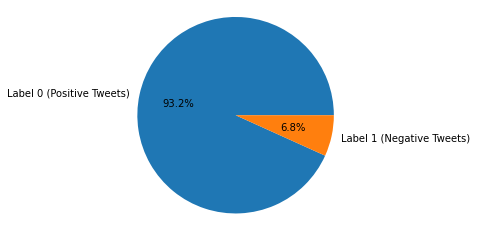

In [15]:
## Analyzing the Imbalance of the the dataset
plt.pie(train_y.value_counts(), labels=['Label 0 (Positive Tweets)', 'Label 1 (Negative Tweets)'], autopct='%0.1f%%')
plt.axis('equal')
plt.show()

### Since the data is highly imblanced thus oversampling is needed to balance ths dataset 

In [16]:
## Using SMOTE Technique oversampling is done
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train_vector, train_y.values)
print(X_train_sm.shape, y_train_sm.shape)

(44056, 29970) (44056,)


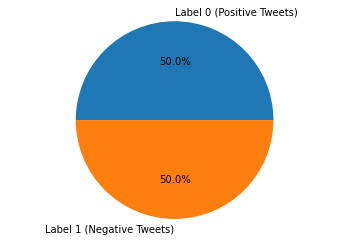

In [17]:
## Thus Now the dataset is balanced
plt.pie(pd.value_counts(y_train_sm), labels=['Label 0 (Positive Tweets)', 'Label 1 (Negative Tweets)'], autopct='%0.1f%%')
plt.axis('equal')
plt.show()

In [18]:
## Function to Train the model
def Training(y_actual, y_predicted):
    ## Accuracy
    accuracy = round(accuracy_score(y_actual, y_predicted), 3)
    ## F1 score
    f1 = round(f1_score(y_actual, y_predicted), 3)
    
    print(f'Training Scores: Accuracy={accuracy}, F1-Score={f1}')
    
## Function to Validate the model
def validation(y_actual, y_predicted):
    ## Accuracy
    accuracy = round(accuracy_score(y_actual, y_predicted), 3)
    ## F1 score
    f1 = round(f1_score(y_actual, y_predicted), 3)
    
    print(f'Validation Scores: Accuracy={accuracy}, F1-Score={f1}')

In [19]:
## Using LinerRegression model
Model1 = LogisticRegression()
Model1.fit(X_train_sm, y_train_sm)

y_train_pred = Model1.predict(X_train_sm)
y_test_pred = Model1.predict(X_test_vector)

Training(y_train_sm, y_train_pred)
validation(test_y, y_test_pred)


Training Scores: Accuracy=0.959, F1-Score=0.958
Validation Scores: Accuracy=0.923, F1-Score=0.586


In [20]:
## Using MultinomialNB Model
Model2 = MultinomialNB()
Model2.fit(X_train_sm, y_train_sm)

y_train_pred = Model2.predict(X_train_sm)
y_test_pred = Model2.predict(X_test_vector)

Training(y_train_sm, y_train_pred)
validation(test_y, y_test_pred)

Training Scores: Accuracy=0.961, F1-Score=0.962
Validation Scores: Accuracy=0.895, F1-Score=0.535


In [21]:
## Using RandomForestClassifier model
Model3 = RandomForestClassifier()
Model3.fit(X_train_sm, y_train_sm)

y_train_pred = Model3.predict(X_train_sm)
y_test_pred = Model3.predict(X_test_vector)

Training(y_train_sm, y_train_pred)
validation(test_y, y_test_pred)

Training Scores: Accuracy=1.0, F1-Score=1.0
Validation Scores: Accuracy=0.956, F1-Score=0.639


### Out of the Models tried, The RandomForestClassifier give the most accurate Result hence we will persist with this model

In [22]:
Model = RandomForestClassifier(criterion='entropy', max_samples=0.8, min_samples_split=10, random_state=0)
Model.fit(X_train_sm, y_train_sm)

y_train_pred = Model.predict(X_train_sm)
y_test_pred = Model.predict(X_test_vector)

Training(y_train_sm, y_train_pred)
validation(test_y, y_test_pred)

Training Scores: Accuracy=0.999, F1-Score=0.999
Validation Scores: Accuracy=0.954, F1-Score=0.648


### Saving the Model using joblib

In [24]:
from joblib import dump, load
dump(Model, 'Tweet_analysis.joblib')

['Tweet_analysis.joblib']

### we need to load to use the model

In [31]:
model = load('Tweet_analysis.joblib')
Tweet = "i Love India"
Tweet = Delete(Tweet)
Tweet = vector.transform([Tweet])
print(Model.predict(Tweet))

[0]
